# Final Project: KorQuAD(The Korean Question Answering Dataset) 2.0 기반 QA task



*   데이터: 아래 링크에서 train과 dev 다운로드    

  https://github.com/korquad/korquad.github.io/tree/master/dataset/KorQuAD_2.0
*   과제 :QA task 실행하는 Sequence to sequence 모델 3가지 이상 훈련시키기  
*   제출 파일명: FinalAssignment_학번_이름.ipynb(etl 업로드 또는 이메일 제출)
*   제출 기한: 2023년 12월 20일 23시 59분  





### 조건  


*   torchtext 사용하여 데이터를 신경망에 입력 가능한 꼴로 변경
*   데이터 전처리  
*   토크나이저 사용하여 토크나이징(공백 기준 분리X)
*   transformer 계열 모델 최소 1개 사용  
*   (선택사항) Train을 training data와 evaluation data로 분리하여 evaluation 구현
*   Inferene 함수 구현
*   dev로 각각의 모델의 F1 score 시각화  

    (주의사항)
    * dev 각 데이터의 난이도를 5개로 분류
    * 질문(question)과 지문(context) 속 중복되는 토큰의 비율에 따라 난이도 측정 가능(중복 토큰 비율이 높을수록 쉬운 지문이고, 중복 토큰 비율이 낮을수록 어려운 지문)
    * 데이터 난이도에 따른 F1 score를 시각화할 것    
    * 아래 논문 5.3 참고   
    https://github.com/korquad/korquad.github.io/blob/master/dataset/KorQuAD_2.0/KorQuAD_2.0_paper.pdf












- 전처리 html 등 잘하기
- 문장 수를 좀 줄여주자.
- max length가 중요하다.
- max 길이가 넘는 데이터셋이 많지 않으면 그런 것들은 버리고 가자.
- 답의 앞 뒤에 special token 잘 붙이자.


# https://github.com/kushalj001/pytorch-question-answering 이것을 참고했다.

# 0. 모듈 다운로드 및 import

In [1]:
!pip install konlpy
!pip install mecab-python3
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 7.1 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports I

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/nlp')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
import torchtext
import torch
import json, re, unicodedata, string, typing, time
import torch.nn.functional as F
import spacy
from collections import Counter
import pickle
import numpy as np
from nltk import word_tokenize
import random
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re, json, glob, argparse
from konlpy.tag import Mecab
import torch
import torchtext
from sklearn.model_selection import train_test_split

In [7]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. preprocessing 및 vocab 만들기



text를 preprocess하는 코드를 정의한다.
html, 이메일, url 등등을 제거한다.

In [8]:
WIKI_REMOVE_CHARS = re.compile("'+|(=+.{2,30}=+)|__TOC__|(ファイル:).+|:(en|de|it|fr|es|kr|zh|no|fi):|\n", re.UNICODE)
WIKI_SPACE_CHARS = re.compile("(\\s|゙|゚|　)+", re.UNICODE)
EMAIL_PATTERN = re.compile("(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", re.UNICODE)
URL_PATTERN = re.compile("(ftp|http|https)?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", re.UNICODE)
WIKI_REMOVE_TOKEN_CHARS = re.compile("(\\*$|:$|^파일:.+|^;)", re.UNICODE)
MULTIPLE_SPACES = re.compile(' +', re.UNICODE)

def preprocess_text(text):
    # HTML 태그 제거
    text = re.sub(r'<[^>]+>', '', text)

    # 정규식 패턴을 사용하여 특정 문자 제거
    text = WIKI_REMOVE_CHARS.sub('', text)

    # 공백 및 유니코드 공백 제거
    text = WIKI_SPACE_CHARS.sub(' ', text).strip()

    # 이메일 및 URL 제거
    text = EMAIL_PATTERN.sub('', text)
    text = URL_PATTERN.sub('', text)

    # 특정 토큰 제거
    text = WIKI_REMOVE_TOKEN_CHARS.sub('', text)

    # 연속된 공백을 하나의 공백으로 치환
    text = MULTIPLE_SPACES.sub(' ', text)

    return text

# 테스트
input_text = "<p>Your HTML <div> text here. URL: http://example.com<p>"
preprocessed_text = preprocess_text(input_text)
print("Input Text:", input_text)
print("Preprocessed Text:", preprocessed_text)


Input Text: <p>Your HTML <div> text here. URL: http://example.com<p>
Preprocessed Text: Your HTML text here. URL: 


tokenizer로 mecab을 사용한다.

In [9]:
mecab=Mecab()
def tokenizer(text):
    tokens = mecab.morphs(text)
    return tokens

In [10]:
def check_answer_in_context(context, answer):
    """
    Check if qa_dict['answer'] is present in qa_dict['context'].

    :param dict qa_dict: Dictionary containing 'context' and 'answer' strings.
    :return: True if 'answer' is present in 'context', False otherwise.
    """
    return answer in context

context="This is a sample context."
answer= "sample"
result = check_answer_in_context(context,answer)

if result:
    print("yes")
else:
    print("no")


yes


이 함수는 주어진 한국어 텍스트를 단어로 토큰화하고, 각 단어의 시작과 끝 위치를 튜플로 구성하여 리스트에 저장 이로써 각 단어의 위치 정보를 쉽게 얻을 수 있음.

In [11]:
def custom_tokenizer(text):
    # 간단한 토크나이징 로직을 사용하여 단어 리스트를 얻음
    words = tokenizer(text)

    # 각 단어의 시작과 끝 위치를 계산하여 리스트에 추가
    current_position = 0
    context_span = []

    for word in words:
        # 주어진 텍스트에서 현재 단어의 시작 위치를 찾음
        word_start = text.index(word, current_position)
        word_end = word_start + len(word)
        context_span.append((word_start, word_end))
        current_position = word_end

    return context_span

# 예시 사용
row_context = "나의 항공 우주,항공이란다. 우주"
#(0,1),(1,2),(3,5),(6,8),(9,11),(11,13),(13,14),(15,)
print(tokenizer(row_context))
context_span = custom_tokenizer(row_context)
print(context_span)


['나', '의', '항공', '우주', ',', '항공', '이', '란다', '.', '우주']
[(0, 1), (1, 2), (3, 5), (6, 8), (8, 9), (9, 11), (11, 12), (12, 14), (14, 15), (16, 18)]


## data read, preprocess, vocab 만들기 등에 필요한 함수를 정의했다.

1. load_json 함수:

JSON 파일을 읽어 Squad 데이터셋을 로드하는 함수입니다.
함수는 파일 경로를 인자로 받아 해당 파일을 열어 JSON 객체로 반환합니다.
함수 내에서는 데이터의 길이, 키 정보 등을 출력하고, 최종적으로 데이터 객체를 반환합니다.

2. parse_data 함수:

Squad 데이터셋의 JSON 파일을 파싱하여 각 예시의 context, query, label 정보를 가진 딕셔너리 리스트를 반환하는 함수입니다.
데이터셋의 'data' 키에서부터 반복문을 통해 context, question, answer를 추출하고, 전처리하여 딕셔너리에 저장합니다.

3. gather_text_for_vocab 함수:

SQUAD 데이터프레임의 컨텍스트와 질문에서 텍스트를 수집하여 어휘를 구축하는 함수입니다.
입력으로 SQUAD 데이터프레임 리스트를 받아 각각의 고유한 컨텍스트와 질문을 리스트에 추가하여 반환합니다.

4. filter_large_examples 함수:

컨텍스트 길이, 질문 길이 및 답변 길이가 특정 임계값을 초과하는 예시의 인덱스를 반환하는 함수입니다.
입력으로 데이터프레임을 받아 임계값을 초과하는 예시의 인덱스를 집합으로 반환합니다.

5. build_word_vocab 함수:

주어진 텍스트에서 단어 수준 어휘를 구축하는 함수입니다.
어휘의 단어와 인덱스 매핑, 정렬된 단어 리스트 등을 반환합니다.

6. build_char_vocab 함수:

주어진 텍스트에서 문자 수준 어휘를 구축하는 함수입니다.
어휘의 문자와 인덱스 매핑, 정렬된 문자 리스트 등을 반환합니다.

7. context_to_ids 함수:

주어진 텍스트의 컨텍스트를 단어 인덱스로 변환하는 함수입니다.
입력으로 텍스트와 단어-인덱스 매핑을 받아 컨텍스트의 단어 인덱스 리스트를 반환합니다.

8. question_to_ids 함수:

주어진 텍스트의 질문을 단어 인덱스로 변환하는 함수입니다.
입력으로 텍스트와 단어-인덱스 매핑을 받아 질문의 단어 인덱스 리스트를 반환합니다.

9. test_indices 함수:

테스트를 수행하고, 시작 및 끝 인덱스가 잘못된 경우의 예시 인덱스를 반환하는 함수입니다.
get_error_indices 함수:

test_indices 함수를 사용하여 에러가 발생한 예시의 인덱스를 집합으로 반환하는 함수입니다.
index_answer 함수:

데이터프레임의 한 행에 대한 답변의 시작과 끝 인덱스를 계산하여 반환하는 함수입니다.

In [12]:
def load_json(path):
    '''
    Loads the JSON file of the Squad dataset.
    Returns the json object of the dataset.
    '''
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    print("Length of data: ", len(data['data']))
    print("Data Keys: ", data['data'][0].keys())
    print("Title: ", data['data'][0]['title'])

    return data
def parse_data(data:dict)->list:
    '''
    Parses the JSON file of Squad dataset by looping through the
    keys and values and returns a list of dictionaries with
    context, query and label triplets being the keys of each dict.
    '''
    data = data['data']
    qa_list = []

    for paragraphs in data:

        # for para in paragraphs['paragraphs']:
            context = paragraphs['context']

            for qa in paragraphs['qas']:

                id = qa['id']
                question = qa['question']
                ans=qa['answer']
                answer = ans['text']


                qa_dict = {}
                qa_dict['id'] = id
                qa_dict['context'] = preprocess_text(context)
                qa_dict['question'] = preprocess_text(question)
                qa_dict['answer'] = preprocess_text(answer)

                ans_start = qa_dict['context'].find(qa_dict['answer'])
                ans_end = ans_start + len(qa_dict['answer'])
                qa_dict['label'] = [ans_start, ans_end]

                if ans_start != -1:
                    qa_list.append(qa_dict)
                else:
                    continue

    return qa_list

def gather_text_for_vocab(dfs:list):
    '''
    Gathers text from contexts and questions to build a vocabulary.

    :param dfs: list of dataframes of SQUAD dataset.
    :returns: list of contexts and questions
    '''

    text = []
    total = 0
    for df in dfs:
        unique_contexts = list(df.context.unique())
        unique_questions = list(df.question.unique())
        total += df.context.nunique() + df.question.nunique()
        text.extend(unique_contexts + unique_questions)

    assert len(text) == total

    return text
def filter_large_examples(df):
    '''
    Returns ids of examples where context lengths, query lengths and answer lengths are
    above a particular threshold. These ids can then be dropped from the dataframe.
    This is explicitly mentioned in QANet but can be done for other models as well.
    '''

    ctx_lens = []
    query_lens = []
    ans_lens = []
    for index, row in df.iterrows():
        ctx_tokens = [w for w in tokenizer(row.context)]
        if len(ctx_tokens)>400:
            ctx_lens.append(row.name)

        query_tokens = [w for w in tokenizer(row.question)]
        if len(query_tokens)>50:
            query_lens.append(row.name)

        ans_tokens = [w for w in tokenizer(row.answer)]
        if len(ans_tokens)>30:
            ans_lens.append(row.name)

        assert row.name == index

    return set(ans_lens + ctx_lens + query_lens)


def build_word_vocab(vocab_text):
    '''
    Builds a word-level vocabulary from the given text.

    :param list vocab_text: list of contexts and questions
    :returns
        dict word2idx: word to index mapping of words
        dict idx2word: integer to word mapping
        list word_vocab: list of words sorted by frequency
    '''


    words = []
    for sent in vocab_text:
        for word in tokenizer(sent):
            words.append(word)

    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    print(f"raw-vocab: {len(word_vocab)}")
    #word_vocab = list(set(word_vocab).intersection(set(glove_words)))
    print(f"glove-vocab: {len(word_vocab)}")
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    print(f"vocab-length: {len(word_vocab)}")
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    print(f"word2idx-length: {len(word2idx)}")
    idx2word = {v:k for k,v in word2idx.items()}


    return word2idx, idx2word, word_vocab

def build_char_vocab(vocab_text):
    '''
    Builds a character-level vocabulary from the given text.

    :param list vocab_text: list of contexts and questions
    :returns
        dict char2idx: character to index mapping of words
        list char_vocab: list of characters sorted by frequency
    '''

    chars = []
    for sent in vocab_text:
        for ch in sent:
            chars.append(ch)

    char_counter = Counter(chars)
    char_vocab = sorted(char_counter, key=char_counter.get, reverse=True)
    print(f"raw-char-vocab: {len(char_vocab)}")
    high_freq_char = [char for char, count in char_counter.items() if count>=20]
    char_vocab = list(set(char_vocab).intersection(set(high_freq_char)))
    print(f"char-vocab-intersect: {len(char_vocab)}")
    char_vocab.insert(0,'<unk>')
    char_vocab.insert(1,'<pad>')
    char2idx = {char:idx for idx, char in enumerate(char_vocab)}
    print(f"char2idx-length: {len(char2idx)}")

    return char2idx, char_vocab
def context_to_ids(text, word2idx):
    context_tokens = [w for w in tokenizer(text)]
    context_ids = [word2idx.get(word, word2idx['<unk>']) for word in context_tokens]
    assert len(context_ids) == len(context_tokens)
    return context_ids

def question_to_ids(text, word2idx):
    question_tokens = [w for w in tokenizer(text)]
    question_ids = [word2idx.get(word, word2idx['<unk>']) for word in question_tokens]
    assert len(question_ids) == len(question_tokens)
    return question_ids

def test_indices(df, idx2word):
    '''
    Performs the tests mentioned above. This method also gets the start and end of the answers
    with respect to the context_ids for each example.

    :param dataframe df: SQUAD df
    :returns
        list start_value_error: example idx where the start idx is not found in the start spans
                                of the text
        list end_value_error: example idx where the end idx is not found in the end spans
                              of the text
        list assert_error: examples that fail assertion errors. A majority are due to the above errors

    '''

    start_value_error = []
    end_value_error = []
    assert_error = []
    for index, row in df.iterrows():

        try:
          answer_tokens = [w for w in tokenizer(row['answer'])]
          if answer_tokens:  # Check if answer_tokens is not empty
                    start_token = answer_tokens[0]
                    end_token = answer_tokens[-1]
          else:
              start_value_error.append(index)
              end_value_error.append(index)
              assert_error.append(index)
        except IndexError as e:
          print(f"Error: {e}")
          print(f"Row answer_tokens content: {answer_tokens}")
          start_value_error.append(index)
          end_value_error.append(index)
          assert_error.append(index)
        # print("end_token",end_token)
        # context_span  = [(word2idx[word], word2idx[word] + len(word))
        #                  for word in tokenizer(row['context'])]
        context_span=custom_tokenizer(row['context'])
        # print("row['context']",tokenizer(row['context']))
        starts, ends = zip(*context_span)
        # print("starts",starts)
        # print("ends",ends)
        try:
            answer_start, answer_end = row['label']
        except ValueError as e:
            cnt+=1
            print(f"Error: {e}")
            print(f"Row label content: {index}")
            start_value_error.append(index)
            end_value_error.append(index)
            assert_error.append(index)
        # answer_start, answer_end = row['label']
        # print("answer_start",answer_start)
        # print("answer_end",answer_end)
        try:
            start_idx = starts.index(answer_start)
        except:
            # print("start",index,row,"\n")
            start_value_error.append(index)
        try:

            end_idx  = ends.index(answer_end)
        except:
            # print("end",index,row,"\n")
            end_value_error.append(index)

        try:

            assert idx2word[row['context_ids'][start_idx]] == answer_tokens[0]
            assert idx2word[row['context_ids'][end_idx]] == answer_tokens[-1]
        except:
            # print("assert",index,row,"\n")
            assert_error.append(index)
        # break
    return start_value_error, end_value_error, assert_error



def get_error_indices(df, idx2word):
    '''
    Gets error indices from the method above and returns a
    set of those indices.
    '''

    start_value_error, end_value_error, assert_error = test_indices(df,idx2word)
    err_idx = start_value_error + end_value_error + assert_error
    err_idx = set(err_idx)
    print(f"Error indices: {len(err_idx)}")

    return err_idx

def index_answer(row, idx2word):
    '''
    Takes in a row of the dataframe or one training example and
    returns a tuple of start and end positions of answer by calculating
    spans.
    '''
    context_span=custom_tokenizer(row.context)
    # context_span = [(word2idx[word], word2idx[word] + len(word)) for word in tokenizer(row.context)]
    # for word in tok(row.context, disable=['parser','tagger','ner']):
    #   print(word.idx)
    #   print(word.text)
    #   print()

    starts, ends = zip(*context_span)

    answer_start, answer_end = row.label
    start_idx = starts.index(answer_start)

    end_idx  = ends.index(answer_end)

    ans_toks = [w for w in tokenizer(row.answer)]
    ans_start = ans_toks[0]
    ans_end = ans_toks[-1]
    assert idx2word[row.context_ids[start_idx]] == ans_start
    assert idx2word[row.context_ids[end_idx]] == ans_end

    return [start_idx, end_idx]

In [13]:
#위의 context length길이를 3000이하로 줄이는 작업 이후에도 cuda out of memory 문제가 지속되기 때문에
#다시 한 번 filtering 해준다.
def filter_large_examples(df):
    '''
    Returns ids of examples where context lengths, query lengths and answer lengths are
    above a particular threshold. These ids can then be dropped from the dataframe.
    This is explicitly mentioned in QANet but can be done for other models as well.
    '''

    ctx_lens = []
    query_lens = []
    ans_lens = []
    for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
        ctx_tokens = [w for w in tokenizer(row.context)]
        if len(ctx_tokens)>1200:
            ctx_lens.append(row.name)

        query_tokens = [w for w in tokenizer(row.question)]
        if len(query_tokens)>50:
            query_lens.append(row.name)

        if isinstance(row.answer, str):
            ans_tokens = [w for w in tokenizer(row.answer)]
            if len(ans_tokens)>30:
              ans_lens.append(row.name)
        else:
            print(row.answer)
            ans_lens.append(row.name)

        assert row.name == index

    return set(ans_lens + ctx_lens + query_lens)

In [14]:
def normalize_spaces(text):
    '''
    Removes extra white spaces from the context.
    '''
    text = re.sub(r'\s', ' ', text)
    return text

In [15]:
def create_word_embedding(glove_dict):
    '''
    Creates a weight matrix of the words that are common in the GloVe vocab and
    the dataset's vocab. Initializes OOV words with a zero vector.
    '''
    weights_matrix = np.zeros((len(word_vocab), 300))
    words_found = 0
    for i, word in enumerate(word_vocab):
        try:
            weights_matrix[i] = glove_dict[word]
            words_found += 1
        except:
            pass
    return weights_matrix, words_found

# 저장한 파일 읽어오기

In [16]:
train_df = pd.read_pickle('./trimmed/train_df.pkl')
with open('./trimmed/word2idx.pickle','rb') as handle:
    word2idx = pickle.load(handle)

In [17]:
idx2word = {v:k for k,v in word2idx.items()}

In [18]:
class SquadDataset:
    '''
    -Divides the dataframe in batches.
    -Pads the contexts and questions dynamically for each batch by padding
     the examples to the maximum-length sequence in that batch.
    -Calculates masks for context and question.
    -Calculates spans for contexts.
    '''

    def __init__(self, data, batch_size):

        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data

    def get_span(self, text):

        return custom_tokenizer(text)

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        '''
        Creates batches of data and yields them.

        Each yield comprises of:
        :padded_context: padded tensor of contexts for each batch
        :padded_question: padded tensor of questions for each batch
        :context_mask & question_mask: zero-mask for question and context
        :label: start and end index wrt context_ids
        :context_text,answer_text: used while validation to calculate metrics
        :context_spans: spans of context text
        :ids: question_ids used in evaluation
        '''

        for batch in self.data:

            spans = []
            context_text = []
            answer_text = []

            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)

            for ctx in batch.context:
                context_text.append(ctx)
                spans.append(self.get_span(ctx))

            for ans in batch.answer:
                answer_text.append(ans)

            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)

            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)

            for i, ques in enumerate(batch.question_ids):
                padded_question[i,: len(ques)] = torch.LongTensor(ques)


            label = torch.LongTensor(list(batch.label_idx))
            context_mask = torch.eq(padded_context, 1)
            question_mask = torch.eq(padded_question, 1)

            ids = list(batch.id)

            yield (padded_context, padded_question, context_mask,
                   question_mask, label, context_text, answer_text, ids)

In [19]:
# create dataloaders
train_dataset = SquadDataset(train_df,4)

In [20]:
a = next(iter(train_dataset))
a[0].shape, a[1].shape, a[2].shape, a[3].shape, a[4].shape

(torch.Size([4, 1190]),
 torch.Size([4, 16]),
 torch.Size([4, 1190]),
 torch.Size([4, 16]),
 torch.Size([4, 2]))

In [68]:
class AlignQuestionEmbedding(nn.Module):

    def __init__(self, input_dim):

        super().__init__()

        self.linear = nn.Linear(input_dim, input_dim)

        self.relu = nn.ReLU()

    def forward(self, context, question, question_mask):

        # context = [bs, ctx_len, emb_dim]
        # question = [bs, qtn_len, emb_dim]
        # question_mask = [bs, qtn_len]

        ctx_ = self.linear(context)
        ctx_ = self.relu(ctx_)
        # ctx_ = [bs, ctx_len, emb_dim]

        qtn_ = self.linear(question)
        qtn_ = self.relu(qtn_)
        # qtn_ = [bs, qtn_len, emb_dim]

        qtn_transpose = qtn_.permute(0,2,1)
        # qtn_transpose = [bs, emb_dim, qtn_len]

        align_scores = torch.bmm(ctx_, qtn_transpose)
        # align_scores = [bs, ctx_len, qtn_len]

        qtn_mask = question_mask.unsqueeze(1).expand(align_scores.size())
        # qtn_mask = [bs, 1, qtn_len] => [bs, ctx_len, qtn_len]

        # Fills elements of self tensor(align_scores) with value(-float(inf)) where mask is True.
        # The shape of mask must be broadcastable with the shape of the underlying tensor.
        align_scores = align_scores.masked_fill(qtn_mask == 1, -float('inf'))
        # align_scores = [bs, ctx_len, qtn_len]

        align_scores_flat = align_scores.view(-1, question.size(1))
        # align_scores = [bs*ctx_len, qtn_len]

        alpha = F.softmax(align_scores_flat, dim=1)
        alpha = alpha.view(-1, context.shape[1], question.shape[1])
        # alpha = [bs, ctx_len, qtn_len]

        align_embedding = torch.bmm(alpha, question)
        # align = [bs, ctx_len, emb_dim]

        return align_embedding

In [151]:
class StackedBiRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.dropout = dropout
        self.num_layers = num_layers
        self.rnns = nn.ModuleList()

        for i in range(self.num_layers):
            input_dim = input_dim if i == 0 else hidden_dim * 2
            self.rnns.append(nn.RNN(input_dim, hidden_dim, batch_first=True, bidirectional=True))

    def forward(self, x):
        outputs = [x]
        for i in range(self.num_layers):
            rnn_input = outputs[-1]
            rnn_out = F.dropout(rnn_input, p=self.dropout)
            rnn_out, hidden = self.rnns[i](rnn_input)
            outputs.append(rnn_out)

        output = torch.cat(outputs[1:], dim=2)
        output = F.dropout(output, p=self.dropout)
        return output

In [161]:

class LinearAttentionLayer(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, question, question_mask):
        qtn = question.view(-1, question.shape[-1])
        attn_scores = self.linear(qtn)
        attn_scores = attn_scores.view(question.shape[0], question.shape[1])
        attn_scores = attn_scores.masked_fill(question_mask == 1, -float('inf'))
        alpha = F.softmax(attn_scores, dim=1)
        return alpha

def weighted_average(x, weights):
    weights = weights.unsqueeze(1)
    w = weights.bmm(x).squeeze(1)
    return w

class BilinearAttentionLayer(nn.Module):

    def __init__(self, context_dim, question_dim):
        super().__init__()
        self.linear = nn.Linear(question_dim, context_dim)

    def forward(self, context, question, context_mask):
        qtn_proj = self.linear(question)
        qtn_proj = qtn_proj.unsqueeze(2)
        scores = context.bmm(qtn_proj)
        scores = scores.squeeze(2)
        scores = scores.masked_fill(context_mask == 1, -float('inf'))
        return scores


In [162]:
class DocumentReader(nn.Module):

    def __init__(self, hidden_dim, embedding_dim, num_layers, num_directions, dropout, device):
        super().__init__()
        self.device = device
        self.context_bilstm = StackedBiRNN(embedding_dim * 2, hidden_dim, num_layers, dropout)

        self.question_bilstm = StackedBiRNN(embedding_dim, hidden_dim, num_layers, dropout)
        self.glove_embedding = self.get_glove_embedding()
        self.align_embedding = AlignQuestionEmbedding(embedding_dim)
        self.linear_attn_question = LinearAttentionLayer(hidden_dim*num_layers*num_directions)
        self.bilinear_attn_start = BilinearAttentionLayer(hidden_dim*num_layers*num_directions,
                                                          hidden_dim*num_layers*num_directions)
        self.bilinear_attn_end = BilinearAttentionLayer(hidden_dim*num_layers*num_directions,
                                                        hidden_dim*num_layers*num_directions)
        self.dropout = nn.Dropout(dropout)

    def get_glove_embedding(self):
        weights_matrix = np.load('./trimmed/glove_vt.npy')
        num_embeddings, embedding_dim = weights_matrix.shape
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device), freeze=False)
        return embedding

    def forward(self, context, question, context_mask, question_mask):
        # print("self.context_bilstm",self.context_bilstm.shape)
        # print("self.question_bilstm",self.question_bilstm.shape)
        ctx_embed = self.glove_embedding(context)
        ques_embed = self.glove_embedding(question)
        ctx_embed = self.dropout(ctx_embed)
        ques_embed = self.dropout(ques_embed)
        align_embed = self.align_embedding(ctx_embed, ques_embed, question_mask)
        ctx_bilstm_input = torch.cat([ctx_embed, align_embed], dim=2)
        ctx_outputs = self.context_bilstm(ctx_bilstm_input)
        qtn_outputs = self.question_bilstm(ques_embed)
        qtn_weights = self.linear_attn_question(qtn_outputs, question_mask)
        qtn_weighted = weighted_average(qtn_outputs, qtn_weights)
        start_scores = self.bilinear_attn_start(ctx_outputs, qtn_weighted, context_mask)
        end_scores = self.bilinear_attn_end(ctx_outputs, qtn_weighted, context_mask)
        return start_scores, end_scores


In [163]:
def weighted_average(x, weights):
    # x = [bs, len, dim]
    # weights = [bs, len]

    weights = weights.unsqueeze(1)
    # weights = [bs, 1, len]

    w = weights.bmm(x).squeeze(1)
    # w = [bs, 1, dim] => [bs, dim]

    return w

In [232]:
def normalize_answer(s):
    '''
    Performs a series of cleaning steps on the ground truth and
    predicted answer.
    '''
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    return white_space_fix(remove_articles(remove_punc(s)))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    Returns maximum value of metrics for predicition by model against
    multiple ground truths.

    :param func metric_fn: can be 'exact_match_score' or 'f1_score'
    :param str prediction: predicted answer span by the model
    :param list ground_truths: list of ground truths against which
                               metrics are calculated. Maximum values of
                               metrics are chosen.


    '''
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)

    return max(scores_for_ground_truths)


def f1_score(prediction, ground_truth):
    '''
    Returns f1 score of two strings.
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    Returns exact_match_score of two strings.
    '''
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def epoch_time(start_time, end_time):
    '''
    Helper function to record epoch time.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [165]:
HIDDEN_DIM = 128
EMB_DIM = 300
NUM_LAYERS = 3
NUM_DIRECTIONS = 2
DROPOUT = 0.3
device = torch.device('cuda')

model = DocumentReader(HIDDEN_DIM,
                       EMB_DIM,
                       NUM_LAYERS,
                       NUM_DIRECTIONS,
                       DROPOUT,device).to(device)

In [166]:
optimizer = torch.optim.Adamax(model.parameters())
from tqdm import tqdm
def train(model, train_dataset):
    '''
    Trains the model.
    '''

    train_loss = 0.
    batch_count = 0

    # put the model in training mode
    model.train()

    # iterate through training data
    for batch in tqdm(train_dataset, desc="Training Batches", unit="batch"):

        context, question, context_mask, question_mask, label, ctx, ans, ids = batch

        # place the tensors on GPU
        context, context_mask, question, question_mask, label = context.to(device), context_mask.to(device),\
                                    question.to(device), question_mask.to(device), label.to(device)
        # print(context.shape, question.shape,context_mask.shape,question_mask.shape)
        # forward pass, get the predictions
        preds = model(context, question, context_mask, question_mask)

        start_pred, end_pred = preds

        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]

        # calculate loss
        loss = F.cross_entropy(start_pred, start_label) + F.cross_entropy(end_pred, end_label)

        # backward pass, calculates the gradients
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

        # update the gradients
        optimizer.step()

        # zero the gradients to prevent them from accumulating
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss/len(train_dataset)

In [170]:
train_losses = []
valid_losses = []
ems = []
f1s = []
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    start_time = time.time()
    train_loss = train(model, train_dataset)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_losses.append(train_loss)

    print(f"Epoch train loss : {train_loss}| Time: {epoch_mins}m {epoch_secs}s")

Epoch 1


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.52batch/s]


Epoch train loss : 5.201458486873005| Time: 1m 18s
Epoch 2


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.51batch/s]


Epoch train loss : 4.511490410507558| Time: 1m 18s
Epoch 3


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.52batch/s]


Epoch train loss : 3.9815999326788214| Time: 1m 18s
Epoch 4


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.46batch/s]


Epoch train loss : 3.5034428708042546| Time: 1m 18s
Epoch 5


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.47batch/s]


Epoch train loss : 3.1215324506864577| Time: 1m 18s
Epoch 6


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.42batch/s]


Epoch train loss : 2.950603112590636| Time: 1m 18s
Epoch 7


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.43batch/s]


Epoch train loss : 2.676171790148402| Time: 1m 18s
Epoch 8


Training Batches: 100%|██████████| 1217/1217 [01:19<00:00, 15.34batch/s]


Epoch train loss : 2.501795038460366| Time: 1m 19s
Epoch 9


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.43batch/s]


Epoch train loss : 2.3906150989810975| Time: 1m 18s
Epoch 10


Training Batches: 100%|██████████| 1217/1217 [01:18<00:00, 15.47batch/s]

Epoch train loss : 2.270774716131118| Time: 1m 18s


In [172]:
model_save_path = f"./trimmed/qanet_epoch_{15}.pth"

In [169]:
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at ./trimmed/qanet_epoch_5.pth


In [ ]:
model.load_state_dict(torch.load(model_save_path))

# Inference

In [173]:
class InfSquadDataset:
    def __init__(self, data, batch_size):

        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data

    def get_span(self, text):
        return custom_tokenizer(text)

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        for batch in self.data:

            spans = []
            context_text = []
            # answer_text = []

            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)

            for ctx in batch.context:
                context_text.append(ctx)
                spans.append(self.get_span(ctx))

            # for ans in batch.answer:
            #     answer_text.append(ans)

            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)

            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)

            for i, ques in enumerate(batch.question_ids):
                padded_question[i,: len(ques)] = torch.LongTensor(ques)


            # label = torch.LongTensor(list(batch.label_idx))
            context_mask = torch.eq(padded_context, 1)
            question_mask = torch.eq(padded_question, 1)

            ids = list(batch.id)

            yield (padded_context, padded_question, context_mask,
                   question_mask, context_text, ids)

In [174]:
question = "M109 자주포가 너무 낡아서 새로운 대안으로 만든것은 무엇일까?"
context = "<!DOCTYPE html>\n<html>\n<head>\n<meta>\n<title>M109 자주포 - 위키백과, 우리 모두의 백과사전</title>\n\n\n<link>\n\n<meta>\n<link>\n<meta>\n<meta>\n<meta>\n<meta>\n<meta>\n<link>\n<link>\n<link>\n<link>\n<link>\n<link>\n<link>\n<link>\n<link>\n<link>\n<link>\n\n</head>\n<body>\n<div></div>\n<div></div>\n<div>\n<a></a>\n<div></div>\n<div>\n</div>\n<h1>M109 자주포</h1>\n<div>\n<div>위키백과, 우리 모두의 백과사전.</div>\n<div></div>\n<div></div>\n<a>둘러보기로 가기</a>\n<a>검색하러 가기</a>\n<div><div><table>\n<caption>M109 155mm 자주포\n</caption>\n<tbody><tr>\n<td colspan=\"2\"><a><img></a>\n</td></tr>\n<tr>\n<th><span>설명 </span>\n</th>\n<td>M109A3형\n</td></tr>\n<tr>\n<th><span>종류 </span>\n</th>\n<td>자주포\n</td></tr>\n<tr>\n<th><span>개발국가 </span>\n</th>\n<td><span><a><img></a></span> <a>미국</a>\n</td></tr>\n<tr>\n<th><span>배치년도 </span>\n</th>\n<td>1963년 ~ 현재\n</td></tr>\n<tr>\n<th colspan=\"2\">역사\n</th></tr>\n<tr>\n<th><span>사용된 전쟁 </span>\n</th>\n<td><a>베트남 전쟁</a>, <a>중동 전쟁</a>, <a>걸프전</a>, <a>아프가니스탄 전쟁</a>, <a>이라크 전쟁</a>\n</td></tr>\n<tr>\n<th><span>개량형 </span>\n</th>\n<td>A1~A6형 까지 다양\n</td></tr>\n<tr>\n<th><span>생산 대수 </span>\n</th>\n<td>2,000대 이상\n</td></tr>\n<tr>\n<th colspan=\"2\">일반 제원\n</th></tr>\n<tr>\n<th><span>승무원 </span>\n</th>\n<td>5명 (지휘관, 사수, 장전수, 운전수, 부운전수)\n</td></tr>\n<tr>\n<th><span>길이 </span>\n</th>\n<td>5.89m,\n</td></tr>\n<tr>\n<th><span>높이 </span>\n</th>\n<td>3.1m\n</td></tr>\n<tr>\n<th><span>폭 </span>\n</th>\n<td>3.2m\n</td></tr>\n<tr>\n<th><span>중량 </span>\n</th>\n<td>21톤(전투중량 25톤)\n</td></tr>\n<tr>\n<th colspan=\"2\">공격력\n</th></tr>\n<tr>\n<th><span>주무장 </span>\n</th>\n<td>M284 155mm 곡사포\n</td></tr>\n<tr>\n<th><span>유효사거리 </span>\n</th>\n<td>18km(M109)~40km(M109A6)\n</td></tr>\n<tr>\n<th><span>부무장 </span>\n</th>\n<td><a>M2 기관총</a> 1정\n</td></tr>\n<tr>\n<th colspan=\"2\">기동력\n</th></tr>\n<tr>\n<th><span>엔진 </span>\n</th>\n<td>디트로이트 디젤 8V71T\n</td></tr>\n<tr>\n<th><span>마력 </span>\n</th>\n<td>405HP\n</td></tr>\n<tr>\n<th><span>현가장치 </span>\n</th>\n<td><a>토션 바</a>\n</td></tr>\n<tr>\n<th><span>노상 속도 </span>\n</th>\n<td>56 km/h\n</td></tr>\n<tr>\n<th><span>기동 가능 거리 </span>\n</th>\n<td>350 km\n</td></tr>\n<tr>\n<th colspan=\"2\">방어력\n</th></tr>\n</tbody></table>\n<p><b>M109 자주포</b>(M109 howitzer)는 <a>미국</a>에서 생산된 <a>자주포</a>로 <a>1962년</a> 생산된 이래 지금까지 많은 미국의 동맹국들과 미국이 사용하고있다.\n</p>\n<div><input><div><h2>목차</h2><span><label></label></span></div>\n<ul>\n<li><a><span>1</span> <span>개요</span></a></li>\n<li><a><span>2</span> <span>대체수단</span></a></li>\n<li><a><span>3</span> <span>파생형</span></a>\n<ul>\n<li><a><span>3.1</span> <span>M109</span></a></li>\n<li><a><span>3.2</span> <span>M109A1/A1B</span></a></li>\n<li><a><span>3.3</span> <span>M109A2</span></a></li>\n<li><a><span>3.4</span> <span>M109A3/A3B</span></a></li>\n<li><a><span>3.5</span> <span>M109A4</span></a></li>\n<li><a><span>3.6</span> <span>M109A5</span></a></li>\n<li><a><span>3.7</span> <span>M109A6 팔라딘</span></a></li>\n<li><a><span>3.8</span> <span>XM2001</span></a></li>\n<li><a><span>3.9</span> <span>XM1203</span></a></li>\n<li><a><span>3.10</span> <span>M109 PIM</span></a></li>\n</ul>\n</li>\n<li><a><span>4</span> <span>사용국가</span></a>\n<ul>\n<li><a><span>4.1</span> <span>M109A1</span></a></li>\n<li><a><span>4.2</span> <span>M109A2/A3</span></a></li>\n<li><a><span>4.3</span> <span>M109A2/A5</span></a></li>\n<li><a><span>4.4</span> <span>M109A4</span></a></li>\n<li><a><span>4.5</span> <span>M109A5</span></a></li>\n<li><a><span>4.6</span> <span>M109A6 Paladin</span></a></li>\n<li><a><span>4.7</span> <span>M109 KAWEST</span></a></li>\n</ul>\n</li>\n<li><a><span>5</span> <span>더 보기</span></a></li>\n<li><a><span>6</span> <span>각주</span></a></li>\n<li><a><span>7</span> <span>외부 링크</span></a></li>\n</ul>\n</div>\n<h2><span></span><span>개요</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<p><a>1962년</a>부터 생산을 해 미국 육군과 해병대 전용이 합해 약 2,000량이 생산되었다.주포를 신형에 환장 하는 등의 개량형(M109A1/A2)에 가세해 새로운 근대화 개수(M109A3A6)를 해 시리즈의 생산 누계는 약 10,000량이라고 하고 있다.M109A6에게만 팔라딘이라고 하는 애칭이 있다.\n</p><p><a>1998</a>년에는 M109의 후계가 되는 XM2001 크루세이더(XM2001 Crusader)의 개발이 시작되었지만, 높은 가격과 50 t에 이르는 대중량이기 때문에 2002년에 개발이 중지되었다 결국 A6형을 지금까지도 사용하고 있다. 미국 이외에도, 여러 미국 동맹국에서 주력자주포로 채용되고있다.\n</p>\n<h2><span></span><span>대체수단</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<p>운용된지 40년이 넘은 M109 자주포는 너무 노후화된 자주포였다. 이에 미군도 이를 느끼고 대체할 방법을 찾는다.\n</p><p>첫 번째 시도로 XM2001을 개발하는 것이였다. XM2001은 분당 12발의 발사속도와 50km의 사정거리로 <a>PzH 2000</a>과 <a>K9 자주포</a>를 제치고 세계 최강이 될 예정이었다. 또한 함께 개발 중이던 XM2002 RSV 보급차량은 막강한 성능으로 한국제 <a>K-10</a>을 능가하는 성능을 가지게 될 예정이었다. 그러나 XM2001은 여러가지 문제로 인해서 도입수량이 824대에서 480대로 줄었고, 포탄 적재량과 항속거리도 감소했다. 이를 살리려는 노력에도 불구하고 결국 2002년 5월 사업은 전면취소 되었다.\n</p><p>두 번째 시도로 FCS 사업을 추진하는 것이였다. 그 중 하나가 XM1203 NLOS-C였다. 전투 중량은 18t, 사거리는 30km로 결정이 되었다. 사업의 빠른 진전으로 FCS 차량사업들 중 가장 빠른 2008년 5월 1호 차량이 등장했다. 그러나 아프가니스탄·이라크에서의 전훈과 미국 경제의 악화로 인해서 결구 2009년 5월 도입사업은 전면폐기되었다.\n</p><p>하지만 너무나도 노후화된 기존 M109를 대체해야 했다. 미군의 자주포 전력은 너무나도 열악했기 때문이다. 이에 새로운 사업이 추진되어 M109 PIM이 등장했다. <a>M2 브래들리</a>의 차체를 이용하여 기동성과 방어력이 상승했고, XM1203에 기술을 적용했다. 2013년부터 580대가 도입될 예정이다. 세계 최강의 군사력을 가진 미국은 정작 자주포 전력은 정치논쟁으로 인한 시간 낭비로 인해서 무려 30년이나 뒤쳐지게 되었다.\n</p>\n<h2><span></span><span>파생형</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<h3><span>M109</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>초기형.1963년생산 개시.M126 155 mm유탄포 및 M127포가를 사용.\n</p>\n<h3><span></span><span>M109A1/A1B</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>장 포신화, 33 구경 MX185 155 mm유탄포에 환장, 최대 사정 18,100m\n</p>\n<div><div><a><img></a> <div><div><a></a></div><a>베트남 전쟁</a>당시 M109</div></div></div>\n<h3><span>M109A2</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>M185 155 mm유탄포 및 M178포가를 사용, 탄약 탑재량 28발에서 36발로 증가\n</p>\n<h3><span></span><span>M109A3/A3B</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>A1/A1B의 A2규격에의 개수형, M127포가를 M178포가에 환장.\n</p>\n<h3><span>M109A4</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>A2 및 A3의 NBC전 대응 능력 향상형.\n</p>\n<h3><span>M109A5</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>M284 155 mm유탄포 및 M182포가를 사용 포르투갈향차량 단가 약 207만$\n</p>\n<h3><span></span><span>M109A6 팔라딘</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>장 포신화, 장갑 강화, 사격 통제 장치의 개량 등, 대폭적인 현대화를 도모한 형태.\n주포에는 39 구경에 장 포신화한 155 mm유탄포 XM284와 AAS(선진형 무장 시스템) 계획으로부터 태어난 155 mm유탄포 XM282, XM283가 있어, XM284는 요금 8의 M208 장약을 이용해 M549A1 로켓 보조 유탄을 30 km까지 날리는 것이 가능했다.\n또 XM282는, 58 구경이라고 하는 장대한 포신장을 가져, 새롭게 개발된 XM244 장약의 사용을 가능하게 해, XM864 베이스·브리드 유탄을 사용했을 경우의 최대 사정은 45 km에도 달했다.\n</p>\n<h3><span>XM2001</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>노후화된 M109 자주포 대체형. 분당 12발 사격 가능, 사거리 50 km. 전면취소.\n</p>\n<h3><span>XM1203</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>노후화된 M109 자주포 대체형. 중량 18t, 사거리 30 km. 전면취소.\n</p>\n<h3><span>M109 PIM</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<p>노후화된 M109 자주포 대체형. 2013년부터 도입.\n</p>\n<h2><span></span><span>사용국가</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<div><div><a><img></a> <div><div><a></a></div>사격 중인 M109A6 팔라딘</div></div></div>\n<h3><span>M109A1</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>덴마크</a> - 76 (A3DK 기종으로 개량됨)</li>\n<li><span><a><img></a></span> <a>에티오피아</a> - 17</li>\n<li><span><a><img></a></span> <a>그리스</a> - 51 A1B</li>\n<li><span><a><img></a></span> <a>쿠웨이트</a> - 5 A1B</li>\n<li><span><a><img></a></span> <a>리비아</a> - 18 A0</li>\n<li><span><a><img></a></span> <a>오만</a> - 15 A0</li>\n<li><span><a><img></a></span> <a>페루</a> - 12</li>\n<li><span><a><img></a></span> <a>사우디아라비아</a> - 28</li>\n<li><span><a><img></a></span> <a>튀니지</a> - 11</li>\n<li><span><a><img></a></span> <a>이란</a> - 390</li></ul>\n<h3><span></span><span>M109A2/A3</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>벨기에</a> - 127 A2 (of which 64 upgraded to A4BE; all now decommissioned) and 40 A3 (sold to Brazil)</li>\n<li><span><a><img></a></span> <a>독일</a> - 570 A3GE A1/A2 (phased out by <a>1 July</a> <a>2007</a>, replaced by the <a>PzH 2000</a>- give up to Greece)</li>\n<li><span><a><img></a></span> <a>그리스</a> - 84 A2, 50 A3GEA1, 196 A3GEA2 (plus 56 A3GEA2 to be used to upgrade the 50 A3GEA1 to A3GEA2 level)<sup><a>[1]</a></sup></li>\n<li><span><a><img></a></span> <a>이집트</a> - 279 A2</li>\n<li><span><a><img></a></span> <a>대한민국</a> - 1,040 (<a>K-55</a>/55A1)</li>\n<li><span><a><img></a></span> <a>모로코</a> - 84</li>\n<li><span><a><img></a></span> <a>노르웨이</a> - 56 A3G (14 upgraded to A3GN, and then 9 of these upgraded to A3GNM to suit the winter climate)</li>\n<li><span><a><img></a></span> <a>파키스탄</a> - 150 A2</li>\n<li><span><a><img></a></span> <a>포르투갈</a></li>\n<li><span><a><img></a></span> <a>태국</a> - 20</li>\n<li><span><a><img></a></span> <a>네덜란드</a> - 126 A2/90 phased out, largely replaced by the <a>PzH 2000</a>.<sup><a>[2]</a></sup></li>\n<li><span><a><img></a></span> <a>브라질</a> - 40 A3 (former Belgian) <a>Brazilian Army</a></li>\n<li><span><a><img></a></span> <a>중화민국</a>(Taiwan) - 225</li></ul>\n<h3><span></span><span>M109A2/A5</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>오스트리아</a> - 80 A2/A5Ö</li></ul>\n<h3><span>M109A4</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>벨기에</a> - 64 A4BE</li></ul>\n<h3><span>M109A5</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>이집트</a> - 201</li>\n<li><span><a><img></a></span> <a>이스라엘</a> - 600 \"Doher\"</li>\n<li><span><a><img></a></span> <a>포르투갈</a></li>\n<li><span><a><img></a></span> <a>태국</a> - 20</li>\n<li><span><a><img></a></span> <a>모로코</a> - 60</li>\n<li><span><a><img></a></span> <a>사우디아라비아</a> - 48</li>\n<li><span><a><img></a></span> <a>바레인</a> - 20</li>\n<li><span><a><img></a></span> <a>이탈리아</a> - 192</li>\n<li><span><a><img></a></span> <a>그리스</a> - 12</li>\n<li><span><a><img></a></span> <a>스페인</a> - 96</li>\n<li>파키스탄 - 130</li></ul>\n<h3><span>M109A6 Paladin</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>미국</a> -1800</li></ul>\n<h3><span>M109 KAWEST</span><span><span>[</span><a>편집</a><span>]</span></span></h3>\n<ul><li><span><a><img></a></span> <a>스위스</a></li>\n<li><span><a><img></a></span> <a>칠레</a> - 24 (former Swiss, upgraded by RUAG.)</li></ul>\n<h2><span></span><span>더 보기</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<ul><li><a>M110 자주포</a></li>\n<li><a>K-9 자주포</a></li>\n<li><a>K-55</a></li>\n<li><a>2S3</a></li></ul>\n<h2><span></span><span>각주</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<div>\n<div><ol>\n<li><span><a>↑</a></span> <span><cite><a>“DefenceNet - «Κοσμογονία» για το πυροβολικό του ΕΣ: Αγοράζονται 36 PzH-2000 και 169 μεταχειρισμένα Μ109Α3GEA2”</a>. 2011년 5월 12일에 <a>원본 문서</a>에서 보존된 문서<span>. 2010년 12월 23일에 확인함</span>.</cite><span><span> </span></span></span>\n</li>\n<li><span><a>↑</a></span> <span>Being phased out in 2007-2008 in favor of the <a>PzH 2000 NL</a>: <cite><a>“Koninklijke Landmacht - \"M109\" (combat support material)”</a> (네덜란드어)<span>. 2006년 8월 24일에 확인함</span>.</cite><span><span> </span></span></span>\n</li>\n</ol></div></div>\n<h2><span></span><span>외부 링크</span><span><span>[</span><a>편집</a><span>]</span></span></h2>\n<table>\n<tbody><tr>\n<td><img></td>\n<td> <b><a>위키미디어 공용</a></b>에 관련된<br/>미디어 자료가 있습니다.\n<div><b><a>M109 자주포</a></b></div> </td>\n</tr>\n</tbody></table>\n<ul><li><b><span>(영어)</span></b> <a>M109A6/M992A2 Sample Data Collection</a></li>\n<li><b><span>(영어)</span></b> <a>Gary's Combat Vehicle Reference Guide</a></li>\n<li><b><span>(영어)</span></b> <a>Fas.org</a></li>\n<li><b><span>(영어)</span></b> <a>Globalsecurity.org</a></li>\n<li><b><span>(영어)</span></b> <a>Israeli-weapons.com</a></li>\n<li><b><span>(영어)</span></b> <a>ruag.com</a></li>\n<li><b><span>(영어)</span></b> <a>Photos of M109 shooting</a>.</li>\n<li><b><span>(영어)</span></b> <a>https://web.archive.org/web/20101218180722/http://www.danskpanser.dk/Baeltekoretojer/M109A3.htm</a> Danish M109 A3]</li></ul>\n<div><table><tbody><tr><th><a>전거 통제</a></th><td><div>\n<ul><li><a>LCCN</a>: <span><a>sh2004000357</a></span></li></ul>\n</div></td></tr></tbody></table></div>\n\n\n\n</div><noscript><img></noscript></div>\n<div>원본 주소 \"<a>https://ko.wikipedia.org/w/index.php?title=M109_자주포&amp;oldid=22405307</a>\"</div>\n<div><div><a>분류</a>: <ul><li><a>미국의 자주포</a></li><li><a>155 mm 포</a></li></ul></div><div>숨은 분류: <ul><li><a>CS1 - 네덜란드어 인용 (nl)</a></li><li><a>LCCN 식별자를 포함한 위키백과 문서</a></li></ul></div></div>\n<div></div>\n</div>\n</div>\n<div>\n<h2>둘러보기 메뉴</h2>\n<div>\n<div>\n<h3>개인 도구</h3>\n<ul>\n<li>로그인하지 않음</li><li><a>토론</a></li><li><a>기여</a></li><li><a>계정 만들기</a></li><li><a>로그인</a></li> </ul>\n</div>\n<div>\n<div>\n<h3>이름공간</h3>\n<ul>\n<li><span><a>문서</a></span></li><li><span><a>토론</a></span></li> </ul>\n</div>\n<div>\n<input>\n<h3>\n<span>변수</span>\n</h3>\n<ul>\n</ul>\n</div>\n</div>\n<div>\n<div>\n<h3>보기</h3>\n<ul>\n<li><span><a>읽기</a></span></li><li><span><a>편집</a></span></li><li><span><a>역사 보기</a></span></li> </ul>\n</div>\n<div>\n<input>\n<h3><span>더 보기</span></h3>\n<ul>\n</ul>\n</div>\n<div>\n<h3>\n<label>검색</label>\n</h3>\n<form>\n<div>\n<input><input><input><input> </div>\n</form>\n</div>\n</div>\n</div>\n<div>\n<div><a></a></div>\n<div>\n<h3>둘러보기</h3>\n<div>\n<ul>\n<li><a>대문</a></li><li><a>사용자 모임</a></li><li><a>요즘 화제</a></li><li><a>최근 바뀜</a></li><li><a>모든 문서 보기</a></li><li><a>임의 문서로</a></li><li><a>도움말</a></li><li><a>기부</a></li> </ul>\n</div>\n</div>\n<div>\n<h3>도구</h3>\n<div>\n<ul>\n<li><a>여기를 가리키는 문서</a></li><li><a>가리키는 글의 최근 바뀜</a></li><li><a>파일 올리기</a></li><li><a>특수 문서 목록</a></li><li><a>고유 링크</a></li><li><a>문서 정보</a></li><li><a>위키데이터 항목</a></li><li><a>이 문서 인용하기</a></li> </ul>\n</div>\n</div>\n<div>\n<h3>다른 프로젝트</h3>\n<div>\n<ul>\n<li><a>위키미디어 공용</a></li> </ul>\n</div>\n</div>\n<div>\n<h3>인쇄/내보내기</h3>\n<div>\n<ul>\n<li><a>책 만들기</a></li><li><a>PDF로 다운로드</a></li><li><a>인쇄용 판</a></li> </ul>\n</div>\n</div>\n<div>\n<h3>다른 언어</h3>\n<div>\n<ul>\n<li><a>العربية</a></li><li><a>Azərbaycanca</a></li><li><a>Brezhoneg</a></li><li><a>Català</a></li><li><a>Deutsch</a></li><li><a>Ελληνικά</a></li><li><a>English</a></li><li><a>Español</a></li><li><a>Eesti</a></li><li><a>Suomi</a></li><li><a>Français</a></li><li><a>עברית</a></li><li><a>Magyar</a></li><li><a>Bahasa Indonesia</a></li><li><a>Italiano</a></li><li><a>日本語</a></li><li><a>Bahasa Melayu</a></li><li><a>Nederlands</a></li><li><a>Norsk</a></li><li><a>Polski</a></li><li><a>Português</a></li><li><a>Русский</a></li><li><a>Slovenščina</a></li><li><a>Svenska</a></li><li><a>ไทย</a></li><li><a>Türkçe</a></li><li><a>Українська</a></li><li><a>中文</a></li> </ul>\n<div><span><a>링크 편집</a></span></div> </div>\n</div>\n</div>\n</div>\n<div>\n<ul>\n<li> 이 문서는 2018년 9월 15일 (토) 17:07에 마지막으로 편집되었습니다.</li>\n<li>모든 문서는 <a>크리에이티브 커먼즈 저작자표시-동일조건변경허락 3.0</a>에 따라 사용할 수 있으며, 추가적인 조건이 적용될 수 있습니다. 자세한 내용은 <a>이용 약관</a>을 참고하십시오.<br/>Wikipedia®는 미국 및 다른 국가에 등록되어 있는 <a>Wikimedia Foundation, Inc.</a> 소유의 등록 상표입니다.</li>\n</ul>\n<ul>\n<li><a>개인정보 정책</a></li>\n<li><a>위키백과 소개</a></li>\n<li><a>면책 조항</a></li>\n<li><a>개발자</a></li>\n<li><a>쿠키 정책</a></li>\n<li><a>모바일 보기</a></li>\n</ul>\n<ul>\n<li>\n<a><img></a> </li>\n<li>\n<a><img></a> </li>\n</ul>\n<div></div>\n</div>\n\n\n\n</body>\n</html>\n"

In [175]:
def qa_inference(model, question, context):
    inf_qa_list = []
    qa_dict = {}
    qa_dict['id'] = 0
    qa_dict['context'] = preprocess_text(context)
    qa_dict['question'] = preprocess_text(question)

    inf_qa_list.append(qa_dict)
    inf_df=pd.DataFrame(inf_qa_list)
    inf_df.context = inf_df.context.apply(normalize_spaces)
    inf_df['context_ids'] = inf_df.context.apply(context_to_ids, word2idx=word2idx)
    inf_df['question_ids'] = inf_df.question.apply(question_to_ids,  word2idx=word2idx)
    inf_dataset = InfSquadDataset(inf_df, 1)
    answer=None
    for batch in inf_dataset:
      context, question, context_mask, question_mask, context_text, ids = batch
      context, question, context_mask, question_mask = context.to(device),question.to(device),context_mask.to(device),question_mask.to(device)

      preds = model(context, question, context_mask, question_mask)
      p1, p2 = preds
      batch_size, c_len = p1.size()
      ls = nn.LogSoftmax(dim=1)
      mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)

      score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
      score, s_idx = score.max(dim=1)
      score, e_idx = score.max(dim=1)
      s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()
      id = ids[0]
      s_idx_value = s_idx.item()
      e_idx_value = e_idx.item()
      pred = context[0][s_idx_value:e_idx_value + 1]
      answer = ' '.join([idx2word[idx.item()] for idx in pred])
    return answer

In [185]:
print(qa_inference(model,question,context))

M 109 자주포 대체 형 . 중량 18 t , 사거리 30 km . 전면 취소 . M 109 <unk> [ 편집 ] 노후 화 된 M 109 자주포 대체 형 . 2013 년 부터 도입 . 사용 국가 [ 편집 ] 사격 중 인 M 109 A 6 팔라딘


# F1 SCORE

# 1. 데이터 로딩 및 preprocessing
2019_17577_정지후_Final_Assignment_1.ipynb 에 있는 preprocessing 코드와 동일하다.

In [194]:
train_data = load_json('unzip/dev/korquad2.0_dev_00.json')
train_list = parse_data(train_data)
train_df=pd.DataFrame(train_list)

Length of data:  1000
Data Keys:  dict_keys(['context', 'qas', 'title', 'url', 'raw_html'])
Title:  2016년_하계_올림픽_배구_남자_선수_명단


In [195]:
for i in range(1,5):
  num = str(i).zfill(2)
  file_name='unzip/dev/korquad2.0_dev_'+num+'.json'
  train_data = load_json(file_name)
  train_list = parse_data(train_data)
  train_df_=pd.DataFrame(train_list)
  train_df =pd.concat([train_df, train_df_], axis=0, ignore_index=True)

Length of data:  1000
Data Keys:  dict_keys(['context', 'qas', 'title', 'url', 'raw_html'])
Title:  상추시
Length of data:  1000
Data Keys:  dict_keys(['context', 'qas', 'title', 'url', 'raw_html'])
Title:  신대철
Length of data:  1000
Data Keys:  dict_keys(['context', 'qas', 'title', 'url', 'raw_html'])
Title:  리히텐슈타인_축구_국가대표팀
Length of data:  736
Data Keys:  dict_keys(['context', 'qas', 'title', 'url', 'raw_html'])
Title:  나고야성_(아이치현)


In [196]:
train_df = train_df[train_df['context'].apply(lambda x: len(str(x)) <= 16000)]

In [197]:
len(train_df)

7858

In [198]:
from tqdm import tqdm
tqdm.pandas()

ctx_lens = []
query_lens = []
ans_lens = []
cnt=0

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):

    ctx_tokens = [w for w in tokenizer(row.context)]
    ctx_lens.append(len(ctx_tokens))

    query_tokens = [w for w in tokenizer(row.question)]
    query_lens.append(len(query_tokens))

    if isinstance(row.answer, str):
        ans_tokens = [w for w in tokenizer(row.answer)]
        ans_lens.append(len(ans_tokens))
    else:
        cnt+=1
        print(row.answer)
        ans_lens.append(0)

100%|██████████| 7858/7858 [01:08<00:00, 114.84it/s]


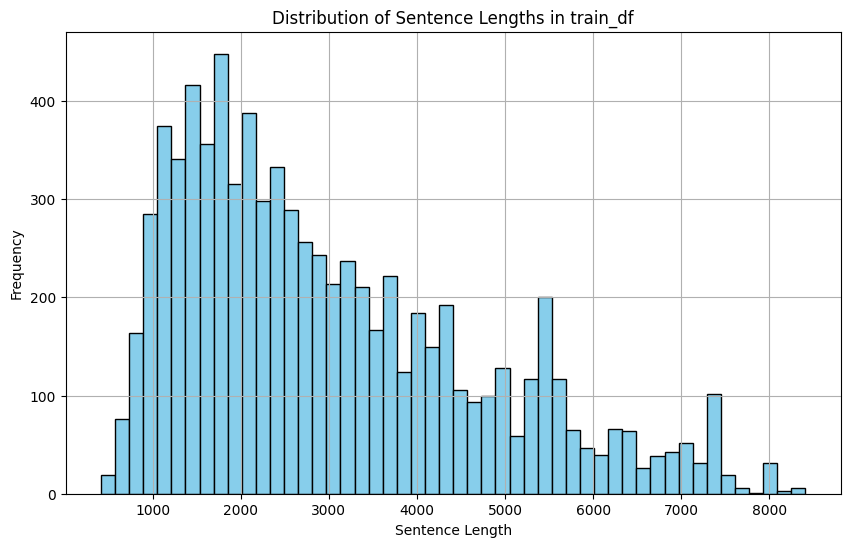

In [199]:
# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(ctx_lens, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths in train_df')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [201]:
def filter_large_examples(df):
    '''
    Returns ids of examples where context lengths, query lengths and answer lengths are
    above a particular threshold. These ids can then be dropped from the dataframe.
    This is explicitly mentioned in QANet but can be done for other models as well.
    '''

    ctx_lens = []
    query_lens = []
    ans_lens = []
    for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
        ctx_tokens = [w for w in tokenizer(row.context)]
        if len(ctx_tokens)>8000:
            ctx_lens.append(row.name)

        query_tokens = [w for w in tokenizer(row.question)]
        if len(query_tokens)>50:
            query_lens.append(row.name)

        if isinstance(row.answer, str):
            ans_tokens = [w for w in tokenizer(row.answer)]
            if len(ans_tokens)>30:
              ans_lens.append(row.name)
        else:
            print(row.answer)
            ans_lens.append(row.name)

        assert row.name == index

    return set(ans_lens + ctx_lens + query_lens)

In [202]:
# get indices of outliers and drop them from the dataframe
drop_ids_train = filter_large_examples(train_df)

100%|██████████| 7858/7858 [01:09<00:00, 113.41it/s]


In [203]:
print(len(drop_ids_train))

1619


In [204]:
train_df.drop(list(drop_ids_train), inplace=True)

In [205]:
len(train_df)

6239

In [206]:
train_df.context = train_df.context.apply(normalize_spaces)

In [207]:
train_df.head(10)

,id,context,question,answer,label
0,38824,"2016년 하계 올림픽 배구 남자 선수 명단 - 위키백과, 우리 모두의 백과사전20...",파스칼레 소틸레의 스파이크 높이는 몇 cm인가?,332cm,"[1225, 1230]"
1,11930,"2016년 하계 올림픽 배구 남자 선수 명단 - 위키백과, 우리 모두의 백과사전20...","2016년 하계 올림픽 캐나다 남자 배구 대표팀 선수들 중, 타일러 샌더스는 201...",MKS 벵진,"[4318, 4324]"
2,40175,"혈액 검사 - 위키백과, 우리 모두의 백과사전혈액 검사위키백과, 우리 모두의 백과사...",혈액 검사에서 나트륨의 정상범위는 최소 136mmol/L에서 최대 몇 mmol/L까...,145,"[1541, 1544]"
3,26058,"안토닌 드보르자크 - 위키백과, 우리 모두의 백과사전안토닌 드보르자크위키백과, 우리...",안토닌 드보르자크의 작품 중 18개의 가곡으로 이루어진 노래는?,사이프러스,"[4467, 4472]"
4,58077,"조석 가속 - 위키백과, 우리 모두의 백과사전조석 가속위키백과, 우리 모두의 백과사...",에드먼드 핼리가 달의 운동이 빨라지고 있다고 주장한 년도는 언제일까?,1695년,"[636, 641]"
5,5343,"조석 가속 - 위키백과, 우리 모두의 백과사전조석 가속위키백과, 우리 모두의 백과사...",지구의 속도를 낮추고 달의 궤도를 올라가게 하는 것은 무엇일까?,중력 토크,"[3596, 3601]"
8,26360,"조영무 - 위키백과, 우리 모두의 백과사전조영무위키백과, 우리 모두의 백과사전.둘러...",조윤을 극적으로 살려준 왕의 이름은?,세종대왕,"[5160, 5164]"
15,73135,"체스터 니미츠 - 위키백과, 우리 모두의 백과사전체스터 니미츠위키백과, 우리 모두의...",일본이 진주만을 공습한 사건이 언제 일어났나요?,1941년 12월 7일,"[2211, 2223]"
16,61137,"체스터 니미츠 - 위키백과, 우리 모두의 백과사전체스터 니미츠위키백과, 우리 모두의...",1907년 니미츠가 임관한 계급은 뭐야?,소위,"[1711, 1713]"
17,48402,"스티비 원더 - 위키백과, 우리 모두의 백과사전스티비 원더위키백과, 우리 모두의 백...",스티비 원더가 눈 수술을 받았다는 루머는 사실인가?,사실이 아니다,"[5492, 5499]"


In [208]:
# numericalize context and questions for training and validation set
train_df['context_ids'] = train_df.context.apply(context_to_ids, word2idx=word2idx)
train_df['question_ids'] = train_df.question.apply(question_to_ids,  word2idx=word2idx)

In [209]:
train_err = get_error_indices(train_df, idx2word)

Error indices: 1306


In [210]:
train_df.drop(train_err, inplace=True)

In [211]:
# get start and end positions of answers from the context
# this is basically the label for training QA models
train_label_idx = train_df.apply(index_answer, axis=1, idx2word=idx2word)
train_df['label_idx'] = train_label_idx

In [213]:
# train_df를 CSV 파일로 저장
train_df.to_csv('./trimmed/dev_data.csv', index=False)

In [217]:
train_df

,id,context,question,answer,label,context_ids,question_ids,label_idx
0,38824,"2016년 하계 올림픽 배구 남자 선수 명단 - 위키백과, 우리 모두의 백과사전20...",파스칼레 소틸레의 스파이크 높이는 몇 cm인가?,332cm,"[1225, 1230]","[215, 7, 777, 376, 2044, 279, 226, 1065, 14, 3...","[0, 1008, 130072, 3, 9418, 1486, 6, 499, 882, ...","[501, 502]"
3,26058,"안토닌 드보르자크 - 위키백과, 우리 모두의 백과사전안토닌 드보르자크위키백과, 우리...",안토닌 드보르자크의 작품 중 18개의 가곡으로 이루어진 노래는?,사이프러스,"[4467, 4472]","[76728, 138935, 14, 36, 5, 58, 60, 3, 70, 7672...","[76728, 138935, 3, 281, 227, 263, 236, 3, 8018...","[2132, 2132]"
4,58077,"조석 가속 - 위키백과, 우리 모두의 백과사전조석 가속위키백과, 우리 모두의 백과사...",에드먼드 핼리가 달의 운동이 빨라지고 있다고 주장한 년도는 언제일까?,1695년,"[636, 641]","[34119, 10083, 14, 36, 5, 58, 60, 3, 70, 34119...","[39689, 103224, 30, 844, 3, 657, 10, 63939, 74...","[308, 309]"
5,5343,"조석 가속 - 위키백과, 우리 모두의 백과사전조석 가속위키백과, 우리 모두의 백과사...",지구의 속도를 낮추고 달의 궤도를 올라가게 하는 것은 무엇일까?,중력 토크,"[3596, 3601]","[34119, 10083, 14, 36, 5, 58, 60, 3, 70, 34119...","[940, 3, 1447, 27, 18761, 35, 844, 3, 4580, 27...","[1797, 1798]"
8,26360,"조영무 - 위키백과, 우리 모두의 백과사전조영무위키백과, 우리 모두의 백과사전.둘러...",조윤을 극적으로 살려준 왕의 이름은?,세종대왕,"[5160, 5164]","[46040, 14, 36, 5, 58, 60, 3, 70, 46040, 36, 5...","[94799, 20, 2668, 55, 34, 12446, 975, 550, 3, ...","[2783, 2784]"
...,...,...,...,...,...,...,...,...
10159,107846,"삼성 갤럭시 S7 엣지 - 위키백과, 우리 모두의 백과사전 삼성 갤럭시 S7 엣지 ...",갤럭시 S7 엣지의 방수 방진 등급은 무엇인가?,IP68,"[4480, 4484]","[929, 2529, 546, 93, 5537, 14, 36, 5, 58, 60, ...","[2529, 546, 93, 5537, 3, 19275, 45638, 2185, 2...","[1944, 1945]"
10160,107847,"삼성 갤럭시 S7 엣지 - 위키백과, 우리 모두의 백과사전 삼성 갤럭시 S7 엣지 ...",2016년도에 중동 지역에서 어떤 휴대폰이 폭발하는 사건이 발생했나?,갤럭시 S7 엣지,"[3, 12]","[929, 2529, 546, 93, 5537, 14, 36, 5, 58, 60, ...","[215, 7, 71, 11, 3411, 331, 37, 776, 26096, 10...","[1, 4]"
10161,107848,"삼성 갤럭시 S7 엣지 - 위키백과, 우리 모두의 백과사전 삼성 갤럭시 S7 엣지 ...",폭발 사고는 출시 이후 몇개월 정도가 지났을때 발생했나?,6개월,"[4937, 4940]","[929, 2529, 546, 93, 5537, 14, 36, 5, 58, 60, ...","[2690, 1050, 6, 1468, 328, 499, 2015, 892, 30,...","[2160, 2161]"
10162,107849,"삼성 갤럭시 S7 엣지 - 위키백과, 우리 모두의 백과사전 삼성 갤럭시 S7 엣지 ...",갤럭시 S7엣지를 만든 회사는?,삼성전자,"[139, 143]","[929, 2529, 546, 93, 5537, 14, 36, 5, 58, 60, ...","[2529, 546, 93, 5537, 27, 1359, 713, 6, 107]","[60, 60]"


#2 중복도 계산

In [218]:
# 토큰화 함수 정의
def tokenize_text(text):
    doc = tokenizer(text)
    return [token for token in doc]

# 'question'과 'context' 열에 대해 토큰화 수행
train_df['question_tokens'] = train_df['question'].apply(tokenize_text)
train_df['context_tokens'] = train_df['context'].apply(tokenize_text)

In [219]:
# 중복된 토큰 비율 계산
def calculate_overlap_ratio(row):
    question_tokens = set(row['question_tokens'])
    context_tokens = set(row['context_tokens'])
    overlap_count = len(question_tokens.intersection(context_tokens))
    total_tokens = len(question_tokens.union(context_tokens))
    overlap_ratio = overlap_count / total_tokens if total_tokens > 0 else 0
    return overlap_ratio

# 각 행에 대해 중복된 토큰 비율 계산
train_df['overlap_ratio'] = train_df.apply(calculate_overlap_ratio, axis=1)

# 중복된 토큰 비율 출력
average_overlap_ratio = train_df['overlap_ratio'].mean()
print(f'평균 중복된 토큰 비율: {average_overlap_ratio:.2%}')

평균 중복된 토큰 비율: 1.50%


In [220]:
# 가장 높은 중복된 토큰 비율을 가진 행
highest_overlap_row = train_df.loc[train_df['overlap_ratio'].idxmax()]

# 가장 낮은 중복된 토큰 비율을 가진 행
lowest_overlap_row = train_df.loc[train_df['overlap_ratio'].idxmin()]

# 결과 출력
print("가장 높은 중복된 토큰 비율을 가진 행:")
print(highest_overlap_row[['question', 'context', 'overlap_ratio']])

print("\n가장 낮은 중복된 토큰 비율을 가진 행:")
print(lowest_overlap_row[['question', 'context', 'overlap_ratio']])


가장 높은 중복된 토큰 비율을 가진 행:
question         키르기스스탄 U-23 축구 국가대표팀은 2014년 AFC U-23 선수권 대회에서 ...
context          키르기스스탄 U-23 축구 국가대표팀 - 위키백과, 우리 모두의 백과사전키르기스스탄...
overlap_ratio                                             0.076087
Name: 7900, dtype: object

가장 낮은 중복된 토큰 비율을 가진 행:
question                                                 표시행위가 뭐야?
context          의사표시 - 위키백과, 우리 모두의 백과사전의사표시위키백과, 우리 모두의 백과사전....
overlap_ratio                                             0.001649
Name: 6089, dtype: object


In [236]:
# overlap_ratio를 5개의 구간으로 나누기 (각 구간이 20%)
train_df['overlap_group'] = pd.qcut(train_df['overlap_ratio'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=False)

# 결과 출력
grouped_df = train_df.groupby('overlap_group').mean()
print(grouped_df[['overlap_ratio']])

               overlap_ratio
overlap_group               
0                   0.006270
1                   0.009935
2                   0.013190
3                   0.017534
4                   0.028069


<ipython-input-236-57214f8495c6>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = train_df.groupby('overlap_group').mean()


In [240]:
len(train_df)

4933

# 3 그룹 나누고 dataset 생성

In [237]:
# 그룹 나누기
group_0_df = train_df[train_df['overlap_group'] == 0].copy()
group_1_df = train_df[train_df['overlap_group'] == 1].copy()
group_2_df = train_df[train_df['overlap_group'] == 2].copy()
group_3_df = train_df[train_df['overlap_group'] == 3].copy()
group_4_df = train_df[train_df['overlap_group'] == 4].copy()

In [238]:
train_dataset0 = SquadDataset(group_0_df,4)
train_dataset1 = SquadDataset(group_1_df,4)
train_dataset2 = SquadDataset(group_2_df,4)
train_dataset3 = SquadDataset(group_3_df,4)
train_dataset4 = SquadDataset(group_4_df,4)

In [239]:
print(len(train_dataset0),len(train_dataset1),len(train_dataset2),len(train_dataset3),len(train_dataset4))

247 247 247 247 247


In [231]:
a = next(iter(train_dataset4))
a[0].shape, a[1].shape, a[2].shape, a[3].shape, a[4].shape

(torch.Size([2, 718]),
 torch.Size([2, 26]),
 torch.Size([2, 718]),
 torch.Size([2, 26]),
 torch.Size([2, 2]))

# 4 f1 score 계산 및 시각화

In [241]:
from tqdm import tqdm
from collections import Counter

def compute_f1_score(model, train_dataset):
    '''
    Computes the F1 score for the model on the training dataset.
    '''

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for F1 score computation
    total_pred_tokens = 0
    total_true_tokens = 0
    total_correct_tokens = 0

    # Iterate through the training data
    for batch in tqdm(train_dataset, desc="Evaluating Batches", unit="batch"):
        context, question, context_mask, question_mask, label, _, _, _ = batch

        # Place the tensors on GPU
        context, context_mask, question, question_mask, label = (
            context.to(device),
            context_mask.to(device),
            question.to(device),
            question_mask.to(device),
            label.to(device),
        )

        # Get model predictions
        preds = model(context, question, context_mask, question_mask)
        p1, p2 = preds

        # Separate labels for start and end position
        start_label, end_label = label[:, 0], label[:, 1]
        batch_size, c_len = p1.size()

        # Compute F1 score for each example in the batch
        for i in range(batch_size):
            start_idx = start_label[i].item()
            end_idx = end_label[i].item()
            pred_start_idx = p1[i].argmax().item()
            pred_end_idx = p2[i].argmax().item()

            # Calculate F1 score for the example
            pred_tokens = list(range(pred_start_idx, pred_end_idx + 1))
            true_tokens = list(range(start_idx, end_idx + 1))
            common_tokens = Counter(pred_tokens) & Counter(true_tokens)
            total_pred_tokens += len(pred_tokens)
            total_true_tokens += len(true_tokens)
            total_correct_tokens += len(common_tokens)

    # Calculate precision, recall, and F1 score
    precision = total_correct_tokens / total_pred_tokens if total_pred_tokens > 0 else 0
    recall = total_correct_tokens / total_true_tokens if total_true_tokens > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1_score


In [245]:
f1_score=[]
f1_score.append(compute_f1_score(model,train_dataset0))
f1_score.append(compute_f1_score(model,train_dataset1))
f1_score.append(compute_f1_score(model,train_dataset2))
f1_score.append(compute_f1_score(model,train_dataset3))
f1_score.append(compute_f1_score(model,train_dataset4))

Evaluating Batches: 100%|██████████| 247/247 [00:10<00:00, 23.58batch/s]


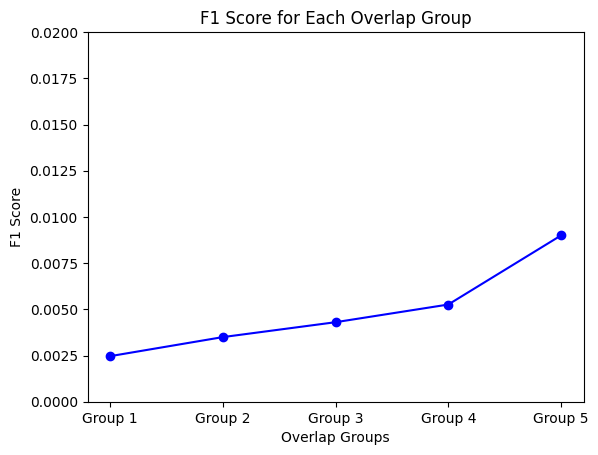

In [251]:
import matplotlib.pyplot as plt

groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
scores = f1_score
plt.plot(groups, scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Overlap Groups')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Overlap Group')
plt.ylim(0, 0.02)

plt.show()